# Project Final Code

## Overview
[Background](#Background)<br>
[Objective](#Objective)<br>
[Setup](#Setup)<br>
[Data Preparation](#Data-Preparation)<br>
[Data Exploration](#Data-Exploration)<br>
- [NLTK comparison with SpaCy and Gensim](#NLTK-comparison-with-SpaCy-and-Gensim)
  - [Run Comparisons](#Run-Comparisons)<br>
- [Exploration of dataset properties using SpaCy](#Exploration-of-dataset-properties-using-SpaCy)
  - [Run Exploration of dataset properties using SpaCy](#Run-Exploration-of-dataset-properties-using-SpaCy)<br>
  
[Modeling](#Modeling)<br>
- [Run Linear SVC](#Run-Linear-SVC)

## Background

I will be using data I scraped from the Android API documentation on this page (https://developer.android.com/reference/packages). Previously my lab published work based on API levels 24 and below, so I will only be using that data. Also, only a subset of this data was annotated so I will list the annotated data's attributes separately. I am including the unannotated data because I will use it for initializing word embeddings, which should help the spaCy model work better.

After annotating, my lab found that very few of of the methods mapped to privacy policy data types so the last catagory is only information regarding these methods. You can clearly see that there is not a lot of data to learn from. This is why I hypothesized that a pre-trained neural model would work well. However, the model would still most likey be used in conjunction with statistical data to make the final classifier. Before then, though, I must compare different baseline text models directly. For reference, my newer deep learning model has been getting on average ~%55 micro f1 and ~%44 macro f1 with this data, and about %10 higher if you use the classes with higher support.

To augment the data I transformed each method's documentation record by splitting it into sentences and adding those as independant instances. I also added a record for each method based on the method's name. This transformation added a lot of noise to the dataset, but it was necessary for any meaningful evaluation.




## Objective
Objective statement:
- I will create baseline classification standards to predict whether an Android API method manipulates/returns information associated with data types defined in privacy policies by using classical sparse vector space representations of the data with standard linear and non-linear classifiers.
- As a secondary objective I will contrast using nltk for text processing and data exploration with using the newer spaCy and gensim packages. 

## Obtaining the Data
The data required for this project may be obtained as follows.

All data files can be found on this github repository (https://github.com/chris414862/DataScienceFinalProj.git). I recommend cloning this repo and running my notebook that is in there. There are some checkpointed files that will make this notebook run a little faster.<br>
To run the code you will have to download:

Gensim
- pip install -U gensim<br>

SpaCy
- pip install -U spacy<br>

and a small SpaCy model
- python -m spacy download en_core_web_sm<br>


## Setup

In [1]:
import os
import csv
from collections import Counter
import re
import numpy as np
import pandas as pd
import pickle
import pprint
import spacy
import nltk

from spacy.tokens import Doc,DocBin
import matplotlib.pyplot as plt
from gensim.summarization.textcleaner import get_sentences
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag, ne_chunk
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.model_selection import KFold

nltk.download('maxent_ne_chunker')
datadir = 'proj_data'
source_filename = 'android_semi_cleaned.csv'
full_filename = 'android_cleaned_FULL.csv' 
annotated_filename = 'android_cleaned_ANNOTATED_ONLY.csv'
mappings_data_filename = 'mappings_cleaned.csv'
cleaned_records_filename = 'records_cleaned.pickle'
source_path = os.path.join(datadir, source_filename)
mappings_path = os.path.join(datadir, mappings_data_filename) 
annotated_path = os.path.join(datadir, annotated_filename)
full_path = os.path.join(datadir, full_filename)
MODEL_COMPARISON_DIR = 'model_comparisons'
nltk_tok_f= 'nltk_tok_by_sent.npy'
spacy_tok_f= 'spacy_tok_by_sent.npy'
tok_diffs_f= 'tok_dif.npy'
nltk_pos_f= 'nltk_pos_by_sent.npy'
spacy_pos_f= 'spacy_pos_by_sent.npy'
nltk_ner_f = 'nltk_ner.npy'
spacy_ner_f= 'spacy_ner.npy'
parsed_docs_f = 'parsed_docs.npy'
doc_partitions = 15

C:\Users\ChrisCrabtree\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\ChrisCrabtree\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


## Data Preparation

Here I access and clean my data. 

### Accessing data

In [2]:
def access_data(path):
    print('Accessing data from:',path)
    with open(path,'r', newline='', encoding='utf-8') as f:
        reader = csv.reader(f, dialect='excel')
        docs = []
        methods = []
        method_documents = {}
        for i, row in enumerate(reader):
            method = row[0]
            doc = row[1] 
            if method in method_documents:
                if [sent for sent in method_documents[method] if sent == doc] == []:
                    method_documents[method].append(doc)
            else:
                method_documents[method] = [doc]
            methods.append(method)
            docs.append(doc)
        return methods, docs, method_documents


### Remove HTML

In [3]:
def my_html_remover(doc):
    return re.sub('''</?\w+((\s+\w+(\s*=\s*(?:".*?"|'.*?'|[\^'">\s]+))?)+\s*|\s*)/?>''','', doc)

### General Cleaning
Here I will only be doing simple cleaning operations in order to demonstrate more clearly the differences between the NLTK and SpaCy packages. Other cleaning such as punctuation removal and lemmatization will not be done here and will be considered later in the presentation. 

In [4]:
def my_cleaner(docs):
    new_docs = []
    for doc in docs:
        # standardize spaces and newlines
        new_doc = re.sub(r'\s+', ' ', doc)
        new_doc = re.sub(r'\s+\.\s+', '. ', new_doc)
        new_doc = my_html_remover(new_doc)
        new_docs.append(new_doc)
    return new_docs

def get_docs(path):
    methods, docs, docs_by_method = access_data(path)
    docs = my_cleaner(docs)
    return pd.DataFrame({'docs': docs, 'methods':methods}), docs_by_method

## Data Exploration

This section will be split into two main sections: [NLTK comparison with SpaCy and Gensim](#NLTK-comparison-with-SpaCy-and-Gensim) and [Exploration of dataset properties using SpaCy](#Exploration-of-dataset-properties-using-SpaCy ) 

### NLTK comparison with SpaCy and Gensim
Here I will show how several common NLP tasks are accomplished (in the context of data exploration) with NLTK and newer packages like SpaCy and Gensim. I will compare each and conclude with an anlaysis of the different approaches. For the purpose of demonstration, I will show SpaCy's functionality in pieces, but normally text processing with SpaCy is pipelined automatically with options for minor alterations.<br><br>
[Overview](#Overview)

#### Sentence tokenization with NLTK

In [5]:
def sent_toks_nltk(docs):
    return [[s.strip(':. "') for s in sent_tokenize(doc)] for doc in docs ]

#### Sentence tokenization with gensim

In [6]:
def sent_toks_gensim(docs):
    return [[s.strip(':. "') for s in get_sentences(doc)] for doc in docs ]

#### Sentence tokenization comparison

In [7]:
def get_differences(orig_docs, nltk_docs, gensim_docs):
    diff_cnt = 0
    diff_orig, diff_nltk, diff_gensim = [],[],[]
    same = []
    for i, (orig_doc, nltk_doc, gensim_doc) in enumerate(zip(orig_docs,nltk_docs, gensim_docs)):        
        # keep track of differences to prevent over-counting
        diff_list=[]
        
        # must search sequentially to track where differences occur. Set operations would lose alignment
        for i, (nltk_sent, gensim_sent) in enumerate(zip(nltk_doc, gensim_doc)):
            
            if (nltk_sent not in gensim_doc or gensim_sent not in nltk_doc) \
                and ([l for l in diff_list if gensim_sent in l or nltk_sent in l] == []):
                diff_cnt += 1
                diff_list.extend([nltk_sent,gensim_sent])
                diff_orig.append(orig_doc)
                diff_nltk.append(nltk_sent)
                diff_gensim.append(gensim_sent)
        
            else:
                same.append(gensim_sent)
    diff_examples = pd.DataFrame({'Original':diff_orig,'nltk':diff_nltk,'gensim':diff_gensim})
    
    return diff_cnt, diff_examples, same
        
        
def compare_sent_tokenization(docs):
    
    nltk_docs_tokenized = sent_toks_nltk(docs)
    gensim_docs_tokenized = sent_toks_gensim(docs)
    diff_cnt, diff_examples, _ = get_differences(docs, nltk_docs_tokenized, gensim_docs_tokenized)
    
    num_nltk_sents = sum([len(d) for d in nltk_docs_tokenized])
    num_gensim_sents = sum([len(d) for d in gensim_docs_tokenized])
    avg_diff_len_nltk = sum([len(d.split()) for d in diff_examples['nltk']])/diff_cnt
    avg_diff_len_gensim = sum([len(d.split()) for d in diff_examples['gensim']])/diff_cnt
    diff_sent_lens = [(len(doc1),len(doc2)) for doc1,doc2 in zip(nltk_docs_tokenized,gensim_docs_tokenized)\
                                                if len(doc1) != len(doc2) ]
    frac_nltk_greater = len(list(filter(lambda x:x[0]>x[1], diff_sent_lens)))/len(diff_sent_lens)
    avg_diff_sents_nltk = sum([len(doc) for doc in nltk_docs_tokenized])/len(nltk_docs_tokenized)
    avg_diff_sents_gensim = sum([len(doc) for doc in gensim_docs_tokenized])/len(gensim_docs_tokenized)
    
    print(f"Total number of documents: {len(docs):,}")
    print(f"Number of differences: {diff_cnt:,}")
    print(f"{'NLTK':>65}{'Gensim':>20}")
    print(f"{'Number of senteces:':>45}{num_nltk_sents:>20,}{num_gensim_sents:>20,}")
    print(f"{'Avg. #tokens of differences:':>45}{avg_diff_len_nltk:>20.3f}{avg_diff_len_gensim:>20.3f}")
    print(f"{'Pct. documents with the most senteces:':>45}{frac_nltk_greater:>20.2%}{(1-frac_nltk_greater):>20.2%}")
    print('\nEXAMPLES OF SENTENCE TOKENIZATION DIFFERENCES:')
    diff_list = []
    printed = 0
    for i,(orig,nltk_sent, gensim_sent) in diff_examples.iterrows():
          if len(orig.split()) > 100:
              continue
          if printed >= 3:
              break
          if orig not in diff_list:
              print('\nORIGINAL:',orig)

          print('NLTK:', nltk_sent)
          print('GENSIM:', gensim_sent)
          diff_list.append(orig)
          printed += 1
    print()
    


#### Tokenization with NLTK

In [8]:
def nltk_tokenize(sent):
    return word_tokenize(sent)

#### Tokenization with SpaCy
SpaCy provides models that are automatically pipelined, so one call will tokenize, tag, and identify named entities. For the purpose of comparison I will show how to only obtain the tokens. Spacy also has a clear API with easy instructions to alter the behavior of it's tokenization. I include functions here that include tokens unique to the Android corpus.

In [9]:
def spacy_tokenize(sent, model):
    return [tok.text for tok in model(sent)]

# Here I search for instances of a method or class (e.g. setStructuredData(String))
def my_retokenizer(doc):
            # methods
    expressions = [r'[A-Za-z_]+(\.[A-Za-z_]+)* ?\( ?[A-Za-z_\.]* ?\)']
    # Camel case w/ periods
    expressions.append(r'(([A-Za-z_]*)\.)+[A-Za-z_]*')
    # General camel case 
    expressions.append(r'[A-Z]?([a-z]+[A-Z])+[a-z]+')
    # Constants
    expressions.append(r'[A-Z_]{4,}')

    compiled_expressions = [re.compile(expression)  for expression in expressions]
    for i,expression in enumerate(compiled_expressions):
            doc = process_match_insertion(doc, expression, ent_label='MT_OR_CL', tok_attrs={'POS' : 'PROPN'})

    return doc


def process_match_insertion(doc, expression, ent_label=None, tok_attrs=None):
    count=0
    for match in re.finditer(expression, doc.text):
        count+=1
        if match.group(0) not in ['e.g.', 'i.e.']:
            start,end = match.span()
            span = doc.char_span(start, end, label = ent_label)
            if span is not None:
                pot_ents = [ent for ent in doc.ents if ent.start >= span.start or ent.end <= span.end]
                if pot_ents != []:
                    new_ents= list(doc.ents)
                    [new_ents.remove(pe) for pe in pot_ents]
                    doc.ents = new_ents
                doc.ents = list(doc.ents) + [span]
                with doc.retokenize() as retokenizer:
                    retokenizer.merge(span, attrs=tok_attrs)
    return doc

#### POS tagging w/ NLTK

In [10]:
def nltk_pos(text):
    return pos_tag(nltk_tokenize(text))

#### POS tagging w/ SpaCy


In [11]:
def spacy_pos(sent, model):
    return [tok.pos_ for tok in model(sent)]

#### NER w/ NLTK

In [12]:
def nltk_ner(text):
    return ne_chunk(nltk_pos(nltk_tokenize(text)))

#### NER w/ SpaCy

In [13]:
def spacy_ner(sent, model):
    return [(ent.text,ent.label_) for ent in model(sent).ents]

#### Functions for Comparisons

In [14]:

def load_comparison_info():
    if MODEL_COMPARISON_DIR in os.listdir():
        print('Loading pre-computed token-level info:')
        filenames = [nltk_tok_f,spacy_tok_f,tok_diffs_f, nltk_pos_f, spacy_pos_f, nltk_ner_f, spacy_ner_f,parsed_docs_f]
        variables = {'nltk_tok':None  ,'spacy_tok':None   ,'tok_diffs' :None  , 'nltk_pos':None   
                     , 'spacy_pos' :None  , 'nltk_ner' :None  , 'spacy_ner':None, 'parsed_docs':None}

        if len([f for f in filenames if f in os.listdir(MODEL_COMPARISON_DIR)]) >= len(filenames)-1:
            for file, variable in zip(filenames, variables.keys()):
                variables[variable] = []
                if variable == 'parsed_docs':
                    
                    for i in range(doc_partitions):
                        batch_file = re.sub(r'\.npy', '', file)+str(i)+'.npy'
                        print('\tLoading',batch_file)
                        file_path = os.path.join(MODEL_COMPARISON_DIR,batch_file) 
                        variables[variable].append(np.load(file_path, allow_pickle=True).tolist())
                    variables[variable] = np.concatenate(variables[variable], axis=0).tolist()
                
                else:
                    print('\tLoading',file)
                    file_path = os.path.join(MODEL_COMPARISON_DIR,file)                 
                    variables[variable] = np.load(file_path, allow_pickle=True).tolist()

        tok_info = (variables['nltk_tok'], variables['spacy_tok'], variables['tok_diffs'])
        pos_info = (variables['nltk_pos'],variables['spacy_pos'])
        ner_info = (variables['nltk_ner'], variables['spacy_ner'])
        return tok_info,pos_info, ner_info, variables['parsed_docs']
    else:
        return None
    
def save_comparison_info(tok_info, pos_info, ner_info, parsed_docs):
    nltk_tok, spacy_tok, tok_diffs = tok_info[0], tok_info[1], tok_info[2]
    nltk_pos, spacy_pos = pos_info[0], pos_info[1]
    nltk_ner, spacy_ner = ner_info[0], ner_info[1]
    try:
        os.makedirs(MODEL_COMPARISON_DIR)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    print('Saving pre-computed token-level info:')
    filenames = [nltk_tok_f,spacy_tok_f,tok_diffs_f, nltk_pos_f, spacy_pos_f, nltk_ner_f, spacy_ner_f, parsed_docs_f]
    variables = [nltk_tok  ,spacy_tok  ,tok_diffs  , nltk_pos  , spacy_pos  , nltk_ner  , spacy_ner, parsed_docs]
    for file, variable in zip(filenames, variables):
        if variable == parsed_docs:
            batch_size = len(parsed_docs)//doc_partitions
            for i in range(doc_partitions):
                batch_file = re.sub(r'\.npy', '', file)+str(i)+'.npy'
                start_idx = i*batch_size
                batch = variable[start_idx: start_idx+batch_size]
                np_var = np.array(batch)
                file_path = os.path.join(MODEL_COMPARISON_DIR,batch_file)
                print('\tSaving to:', file_path)
                np.save(file_path, np_var)
        else:
            np_var = np.array(variable)
            file_path = os.path.join(MODEL_COMPARISON_DIR,file)
            print('\tSaving to:', file_path)
            np.save(file_path, np_var)
            
            
def process_docs(docs, methods, compute_comparison_info=True):
    # Initialize SpaCy model
    model = spacy.load('en_core_web_sm')
    model.add_pipe(my_retokenizer, first=True)    

    # Split docs to sentences using gensim. Attach method name to each sentence for later reference
    total_docs = [(method,sent) for method,doc in zip(methods,sent_toks_gensim(docs)) for sent in doc]
    
    # Separate methods and (sentence level) docs
    total_docs_transpose = list(zip(*total_docs))
    methods = total_docs_transpose[0]
    docs = total_docs_transpose[1]

    ##### THIS IS THE LOOP FOR PROCESSING DOCUMENTS #####
    print(f'Documents to process: {len(docs):,}')
    nltk_tok, spacy_tok, nltk_pos, spacy_pos, nltk_ner, spacy_ner, parsed_docs =[],[],[],[],[],[],[]
    for i, doc in enumerate(model.pipe(docs, disable=["parser"])):
        if i %5000 ==0:
            print(f'Processed {i:,}')
        if compute_comparison_info:
            nltk_sent_toks = nltk_tokenize(doc.text)
            nltk_tok.append(nltk_sent_toks)
            nltk_sent_pos_tags = pos_tag(nltk_sent_toks)
            nltk_pos.append(nltk_sent_pos_tags)
            nltk_sent_ne = [(' '.join([l[0] for l in ne.leaves()]),ne.label()) for ne in ne_chunk(nltk_sent_pos_tags)
                            if type(ne) == nltk.tree.Tree]
            nltk_ner.append(nltk_sent_ne)

            spacy_tok.append([tok.text for tok in doc])
            spacy_pos.append([(tok.text,tok.pos_) for tok in doc])
            spacy_ner.append([(ent.text, ent.label_) for ent in doc.ents])
            #doc.set_extension('method_label', default=methods[i], force=True)
        parsed_docs.append((methods[i], doc))
        
    if compute_comparison_info:
        tok_diffs = [(nltk_tok_sent,spacy_tok_sent) for nltk_tok_sent, spacy_tok_sent in zip(nltk_tok,spacy_tok)
                                          if len(nltk_tok_sent) != len(spacy_tok_sent)]
        tok_info = (nltk_tok, spacy_tok, tok_diffs)
        pos_info = (nltk_pos,spacy_pos)
        ner_info = (nltk_ner, spacy_ner)
        return tok_info, pos_info, ner_info, parsed_docs
    

def model_comparison_info(df):
    '''
    This functions gets the token, pos tags, and named entities for all docs using both nltk and Spacy methods.
    This is expensive to compute so the results are stored and later uploaded in leiu of computation.
    '''
    comparison_info = load_comparison_info()
    docs = df['docs']
    methods = df['methods']
    if comparison_info is not None:
        #parsed_docs = process_docs(docs, methods, compute_comparison_info=True)
        return (comparison_info)

    tok_info, pos_info, ner_info,parsed_docs = process_docs(docs, methods, compute_comparison_info=True)
    save_comparison_info(tok_info, pos_info, ner_info, parsed_docs)
    return tok_info,pos_info, ner_info, parsed_docs

def show_tok_diffs(nltk_tok, spacy_tok, diff_docs):
    print('\nTokenization differences')
    nltk_tot_tokens = sum([len(sent) for sent in nltk_tok])
    spacy_tot_tokens = sum([len(sent) for sent in spacy_tok])
    nltk_avg_tokens_tot = nltk_tot_tokens/len(nltk_tok)
    spacy_avg_tokens_tot = spacy_tot_tokens/len(spacy_tok)
    nltk_tot_toks_of_diff = sum([len(y) for y in [x for x in zip(*diff_docs)][0]])
    spacy_tot_toks_of_diff = sum([len(y) for y in [x for x in zip(*diff_docs)][1]])
    nltk_avg_tokens_diff = nltk_tot_toks_of_diff/len(diff_docs)
    spacy_avg_tokens_diff = spacy_tot_toks_of_diff/len(diff_docs)
    print(f'Number of documents with different tokenization: {len(diff_docs)} ', end='')
    print(f'Fraction of total: {len(diff_docs)/ len(nltk_tok):.2%}')
    print(f"{'NLTK':>65}{'SpaCy':>20}")
    print(f"{'Number of tokens:':>45}{nltk_tot_tokens:>20,}{spacy_tot_tokens:>20,}")
    print(f"{'Avg. tokens per sentence:':>45}{nltk_avg_tokens_tot:>20,.3f}{spacy_avg_tokens_tot:>20,.3f}")
    print(f"{'Number of tokens of differences:':>45}{nltk_tot_toks_of_diff:>20,}{spacy_tot_toks_of_diff:>20,}")
    print(f"{'Avg. #tokens of differences:':>45}{nltk_avg_tokens_diff:>20.3f}{spacy_avg_tokens_diff:>20.3f}")
    print('\nExamples of differences:')
    pp = pprint.PrettyPrinter(indent=2, width=110)
    printed = 0
    for i, (nltk_toks, spacy_toks) in enumerate(diff_docs):
          if len(nltk_toks) > 10 or len(spacy_toks) > 10:
              continue
          if printed >= 3:
              break
          print('\nNLTK:')
          pp.pprint(nltk_toks)
          print('SpaCy:')
          pp.pprint(spacy_toks)
          printed+=1
    print('\n')      
    
def show_example_diffs(info, title_string, tok_limit, num_examples):
    nltk_examples, spacy_examples = info[0], info[1]
    pp = pprint.PrettyPrinter(indent=2, width=180)
    printed = 0
    print(title_string)
    for i, (nltk, spacy) in enumerate(zip(nltk_examples, spacy_examples)):
          if len(nltk) > tok_limit or len(spacy) > tok_limit:
              continue
          if printed >= num_examples:
              break
          print('\nNLTK:')
          pp.pprint(nltk)
          print('SpaCy:')
          pp.pprint(spacy)
          printed+=1
    print('\n')
    



### Run Comparisons

In [15]:
df, docs_by_method = get_docs(source_path)
compare_sent_tokenization(df['docs'].to_list())
tok_info,pos_info, ner_info, parsed_docs = model_comparison_info(df)
nltk_toks, spacy_toks, tok_diffs = tok_info
show_tok_diffs(nltk_toks, spacy_toks, tok_diffs)
show_example_diffs(pos_info,'EXAMPLES OF DIFFERENCES IN POS TAGGING', 6,3)
show_example_diffs(ner_info,'EXAMPLES OF DIFFERENCES IN POS TAGGING(MT_OR_CL IS METHOD OR CLASS)',6,3)


Accessing data from: proj_data\android_semi_cleaned.csv
Total number of documents: 29,402
Number of differences: 553
                                                             NLTK              Gensim
                          Number of senteces:              73,109              73,154
                 Avg. #tokens of differences:              19.443              20.671
       Pct. documents with the most senteces:              47.20%              52.80%

EXAMPLES OF SENTENCE TOKENIZATION DIFFERENCES:

ORIGINAL: Called by a device admin to set the short support message. This will be displayed to the user in settings screens where funtionality has been disabled by the admin. The message should be limited to a short statement such as "This setting is disabled by your administrator. Contact someone@example.com for support." If the message is longer than 200 characters it may be truncated. If the short support message needs to be localized it is the responsibility of the DeviceAdminRecei

### Exploration of dataset properties using SpaCy 
For this section we will explore the differences between the different subset in our data. As a reminder the sets are (from largest to smallest): the full set of unannotated data, the annotated data, and the data that positively map to privacy policy terms. <br><br>
[Overview](#Overview)


In [16]:


def doc_info(docs):
    '''
    Returns the parsed document, the token counter, POS tag counter,and the POS tag counter by word 
    '''
#     nlp = spacy.load("en_core_web_sm", disable=["parser", 'ner'])
#     nlp.add_pipe(my_retokenizer, first=True)
    tok_cnt = Counter()
    pos_cnt = Counter()
    pos_byword_cnt = {}
    parsed_docs = []
    for method, doc in docs:
        #doc = tup[1]
        #parsed_docs.append((tup[0], doc))
        for i, tok in enumerate(doc):
            tok_cnt[tok.text] += 1
            pos_cnt[tok.pos_] += 1
            if tok.pos_ in pos_byword_cnt:
                pos_byword_cnt[tok.pos_][tok.text] +=1
            else:
                pos_byword_cnt[tok.pos_] = Counter()
                pos_byword_cnt[tok.pos_][tok.text] += 1
                
    return tok_cnt, pos_cnt, pos_byword_cnt         


def display_info(parsed_docs, method_documents,tok_cnt, pos_cnt, pos_byword_cnt, classes=None):
    unique_sents = Counter()
    unique_docs = []
    
    for method,doc in parsed_docs:
        if doc.text not in unique_sents:
            unique_docs.append((method,doc))
        unique_sents[doc.text] +=1   
   
    if classes:
        print('\t>-total number of classes:', len(set(classes)), '<br>')
        print('\t -total number of methods:', len(method_documents.keys()), '<br>')
    else:
        print('\t>-total number of methods:', len(method_documents.keys()), '<br>')
    print('\t -total records after transform:', len(parsed_docs), '<br>')
    print('\t -number of unique records after transform:', len(unique_sents), '<br>')
    print('\t -method with most sentences:', max([(key,len(method_documents[key])) for key in method_documents]
                                             , key=lambda x: x[1]), '<br>')
    print('\t -method with most tokens:', max([(method,len(doc)) for method,doc in unique_docs]
                                             , key=lambda x: x[1]), '<br>')
    print('\t -total number of tokens:', sum([tok_cnt[key] for key in tok_cnt.keys()]), '<br>')
    print("\t -num unique tokens:", len(tok_cnt.keys()), '<br>')
    print('\t -most common tokens (with 5 or more chars):'
          ,[tup for tup in tok_cnt.most_common() if len(tup[0])>4][:3], '<br>')
    most_freq_pos = pos_cnt.most_common(1)[0][0]
    print('\t -most frequent POS tag:', most_freq_pos, '<br>')
    print('\t -most common words in that tag:', pos_byword_cnt[most_freq_pos].most_common(1)[0], '<br>')
    print('\t -most frequent proper noun:', pos_byword_cnt['PROPN'].most_common(1)[0], '<br>')
    method_and_class_toks = [ent.text for _,p_doc in parsed_docs for ent in p_doc.ents 
                             if ent.label_ == 'MT_OR_CL']
    print('\t -number of unique domain-specific named entities:', len(method_and_class_toks), '<br>')
    print('\t -number of unique domain-specific named entities:', len(set(method_and_class_toks)), '<br>')
    print('\t -most frequent domain-specific named entity:'
          , Counter(method_and_class_toks).most_common()[0], '<br>')
    print()

def get_subset(parsed_docs, path, docs_by_method):
    subset_methods,subset_info, _ = access_data(path)
    #mapping_docs = list(zip(methods,info))
    classes = list(set(subset_info))
    #mapped_methods = [mapping_doc[0] for mapping_doc in mapping_docs]
    #info = [mapping_doc[1] for mapping_doc in mapping_docs]
    sub_meth_dict = {key:None for key in subset_methods}
    docs = [(method, doc) for method,doc in parsed_docs if method in sub_meth_dict]
    
    docs_by_method = {key:docs_by_method[key] for key in docs_by_method.keys() if key in subset_methods}
    return docs, docs_by_method, classes
    
    
def process_doc_and_display_attrs(parsed_docs, mappings_path=None, docs_by_method=None, annotated_path=None):
    docs = parsed_docs
    classes = None
    if annotated_path:
        
        docs, docs_by_method, _ = get_subset(docs, annotated_path, docs_by_method)
    if mappings_path:
        docs, docs_by_method, classes = get_subset(docs, mappings_path, docs_by_method)
        
    tok_cnt, pos_cnt, pos_byword_cnt = doc_info(docs) 
    if mappings_path == annotated_path ==None:
        print('INFO FOR',source_path)
    elif mappings_path ==None:
        print('INFO FOR',annotated_path)
    else:
        print('INFO FOR',mappings_path)
    display_info(docs, docs_by_method, tok_cnt, pos_cnt, pos_byword_cnt, classes=classes)
    return docs, tok_cnt

#### Data visualization functions

In [17]:
def autolabel(rects,axs):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axs.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
        
def make_stacked_plot(ax_list, dataset, titles, width,min_word_len=0, num_words=10):
    for i in range(3):
        
        common_words = [tup for tup in dataset[i].most_common() if len(tup[0]) >= min_word_len]
        xs = np.arange(num_words)

        labels = [tup[0] for tup in common_words[:num_words]]
        ys = [tup[1] for tup in common_words[:num_words]]
        ax_list[i].bar(xs, ys,width )
        ax_list[i].set_xticks(xs)
        ax_list[i].set_title(titles[i], fontsize=20)
        ax_list[i].set_xticklabels(labels, fontdict={'fontsize':13}, rotation=30, ha="right")


def first_plot():
    xs = np.arange(3)+1
    width = .25
    dataset = [ unann_parsed_docs, ann_parsed_docs,mapped_parsed_docs]
    dataset_names = ['unannotated methods', 'annotated methods', 'mapped methods only']

    fig, axs = plt.subplots(figsize=(8,8))
    ys = [len(set([doc[0] for doc in data])) for data in dataset]
    rects1 = axs.bar(xs+width/2,ys, width, label='Original')
    ys = [len( data) for data in dataset]
    rects2 = axs.bar(xs-width/2 ,ys, width, label='Transformed')
    axs.set_xticks(xs)

    autolabel(rects1, axs)
    autolabel(rects2, axs)
    axs.legend()
    axs.set_title('Effect of transformation on records', fontsize=20)
    axs.set_xticklabels(dataset_names, fontdict={'fontsize':12})
    plt.show()
    
    
def second_plot():    


    width = .25
    num_words = 10
    min_word_len = 5

    dataset = [unann_tok_cnt,ann_tok_cnt,mapped_tok_cnt]
    dataset_names = ['unannotated methods', 'annotated methods', 'mapped methods only']
    title_template = 'Most common words longer than '+str(min_word_len)+' for '
    titles = [title_template+dataset_names[i] for i in range(len(dataset))]

    fig, ax_list = plt.subplots(3,1,figsize=(10,13))
    make_stacked_plot(ax_list, dataset, titles, width, min_word_len, num_words)


    fig.tight_layout()
    plt.show()
    
def third_plot():
    plt.close()
    width = .25
    num_words = 10

    dataset_ent = [ unann_parsed_docs, ann_parsed_docs,mapped_parsed_docs]
    dataset_names = ['unannotated methods', 'annotated methods', 'mapped methods only']
    title_template = 'Most common domain-specific named entities for '
    titles = [title_template+dataset_names[i] for i in range(len(dataset_ent))]
    ent_counters = [Counter() for i in range(len(dataset_ent))]



    for i in range(len(ent_counters)):
        for j in range(len(dataset_ent[i])):
            for ent in dataset_ent[i][j][1].ents:
                  if ent.label_ == 'MT_OR_CL':
                    ent_counters[i][ent.text] +=1

    
    fig, ax_list2 = plt.subplots(3,1,figsize=(10,15))
    make_stacked_plot(ax_list2, ent_counters, titles, width, 0, num_words)


    fig.tight_layout()
    plt.show()
    
def fourth_plot():
    width = .25
    dataset = [ unann_parsed_docs, ann_parsed_docs,mapped_parsed_docs]

    dataset_names = ['unannotated methods', 'annotated methods', 'mapped methods only']
    title_template = 'Number of unique tokens by tag for '
    titles = [title_template+dataset_names[i] for i in range(len(dataset))]
    ent_counters = [Counter() for i in range(len(dataset))]
    total_ents = [len(set(ent_counters[i].elements())) for i in range(len(ent_counters))]
    pos_counters = [{} for i in range(len(dataset))]

    for i in range(len(pos_counters)):
        for j in range(len(dataset[i])):
            for tok in dataset[i][j][1]:
                if tok.pos_ in pos_counters[i]:
                    pos_counters[i][tok.pos_][tok.text] +=1

                else:
                    pos_counters[i][tok.pos_] = Counter()
                    pos_counters[i][tok.pos_][tok.text] +=1

    fig, ax_list = plt.subplots(3,1,figsize=(10,15))

    for i in range(3):


        d = [('DS ENTITY',total_ents[i])]+[(key,len(pos_counters[i][key].keys())) for key in pos_counters[i]]
        d = sorted(d, key=lambda x: x[1], reverse=True)
        labels = [item[0] for item in d]
        ys = [item[1] for item in d]
        xs = np.arange(len(labels))
        ax_list[i].bar(xs, ys,width )
        ax_list[i].set_xticks(xs)
        ax_list[i].set_title(titles[i], fontsize=20)
        ax_list[i].set_xticklabels(labels, fontdict={'fontsize':13}, rotation=30, ha="right")

    fig.tight_layout()
    plt.show()  

### Run Exploration of dataset properties using SpaCy 
[Overview](#Overview)

INFO FOR proj_data\android_semi_cleaned.csv
	>-total number of methods: 25954 <br>
	 -total records after transform: 73140 <br>
	 -number of unique records after transform: 45185 <br>
	 -method with most sentences: ('android.junit.framework.Assert.assertEquals', 19) <br>
	 -method with most tokens: ('android.java.util.logging.SimpleFormatter.format', 171) <br>
	 -total number of tokens: 1166514 <br>
	 -num unique tokens: 24990 <br>
	 -most common tokens (with 5 or more chars): [('method', 13776), ('object', 7005), ('value', 6569)] <br>
	 -most frequent POS tag: NOUN <br>
	 -most common words in that tag: ('method', 13699) <br>
	 -most frequent proper noun: ('API', 1233) <br>
	 -number of unique domain-specific named entities: 25074 <br>
	 -number of unique domain-specific named entities: 6646 <br>
	 -most frequent domain-specific named entity: ('hashCode', 785) <br>

Accessing data from: proj_data\android_cleaned_ANNOTATED_ONLY.csv
INFO FOR proj_data\android_cleaned_ANNOTATED_ONLY.csv


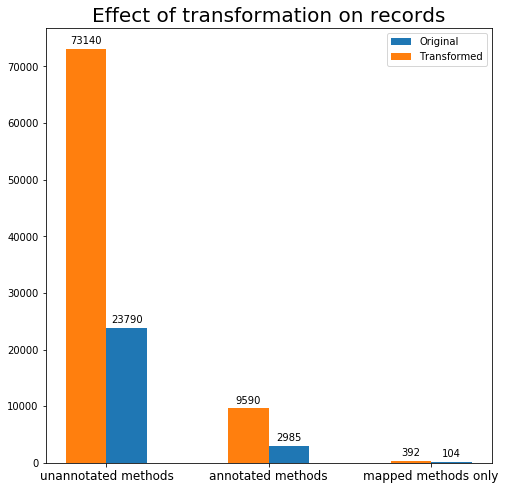

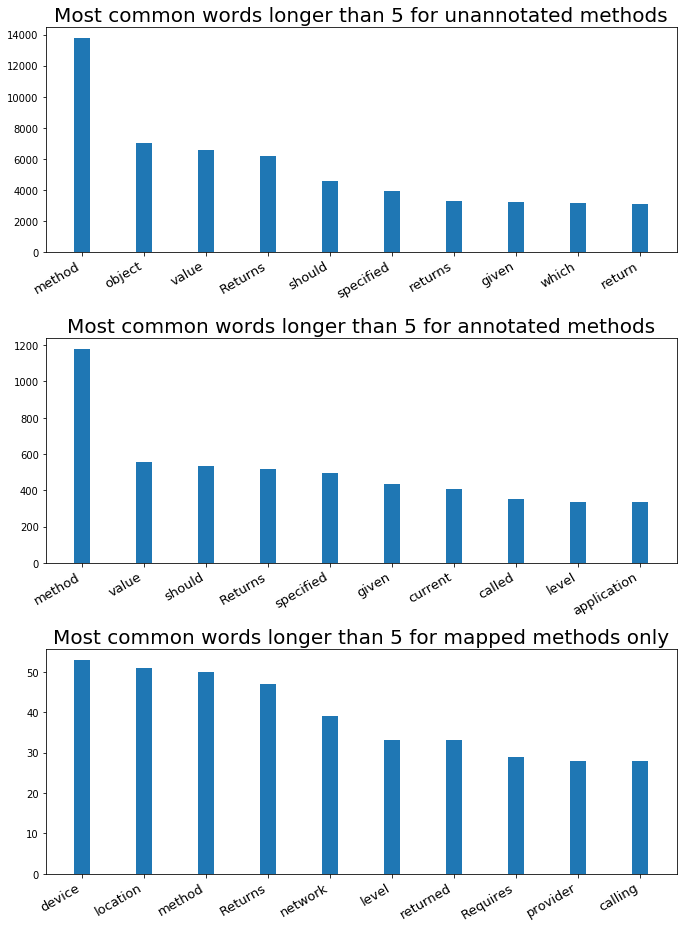

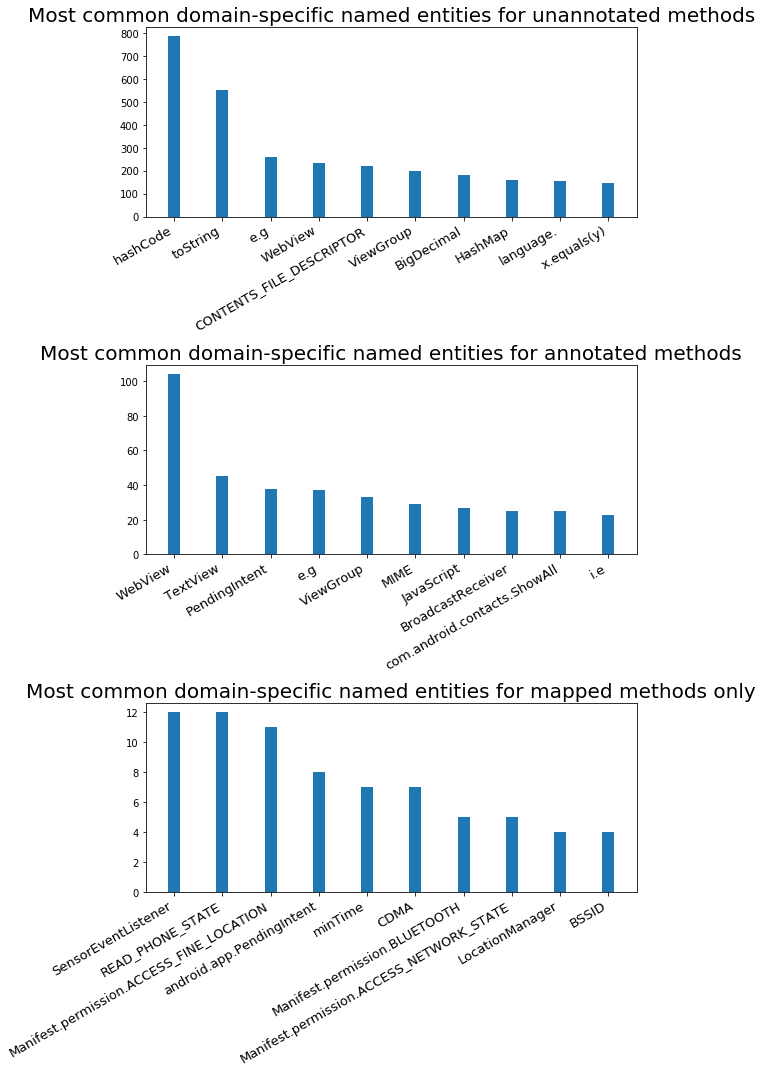

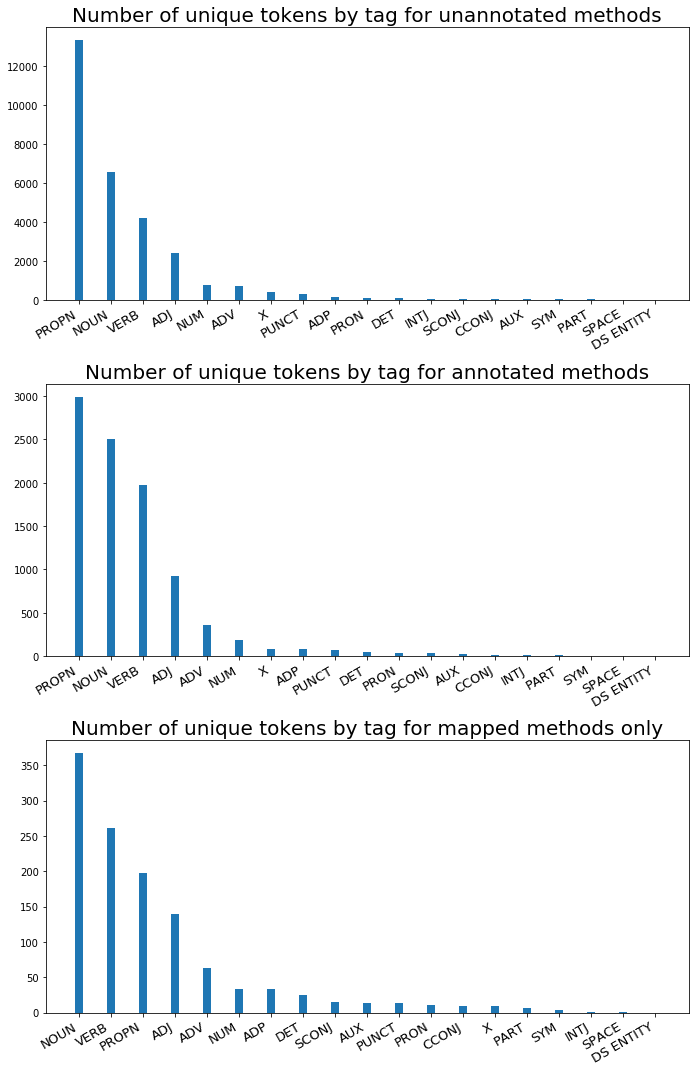

In [18]:

unann_parsed_docs, unann_tok_cnt = process_doc_and_display_attrs(parsed_docs
                                                                 , docs_by_method=docs_by_method)
ann_parsed_docs, ann_tok_cnt = process_doc_and_display_attrs(parsed_docs
                                                            , annotated_path=annotated_path
                                                            , docs_by_method=docs_by_method)
mapped_parsed_docs, mapped_tok_cnt = process_doc_and_display_attrs(parsed_docs
                                                                   , annotated_path=annotated_path
                                                                   , mappings_path=mappings_path
                                                                   , docs_by_method=docs_by_method)
first_plot()
second_plot()
third_plot()
fourth_plot()

## Modeling

Due to severeve class imbalance, a proper train, dev, test split is not possible. Instead, I will display the results of a k-fold crossvalidation run.<br><br>
[Overview](#Overview)

In [19]:
def make_mapped_only(mappings_path, docs, mapped_methods):   
    mapping_docs, _ = access_data(mappings_path) 
    mapped_methods = [mapping_doc[0] for mapping_doc in mapping_docs]
    classes = [mapping_doc[1] for mapping_doc in mapping_docs]
    docs = [doc for doc in docs if doc[0] in mapped_methods]
    doc_by_method = {key:doc_by_method[key] for key in doc_by_method.keys() if key in mapped_methods}
    return docs, doc_by_method

class record():
    def __init__(self, method=None, text=None, tokens=None, label=None):
        self.method = method
        self.text = text
        self.tokens = tokens
        self.label = label
        
    def to_string(self):
        return(self.text)
    
class my_records():
    pass

def convert_docs_to_records(docs):
    records = []
    for doc in docs:
        records.append(record(method=doc[0], text=doc[1]))
        #records.append(record(method=doc[0], text=doc[1], tokens=[tok.text for tok in doc[1]]))
    return records

def tokenize_and_clean_records(records):
    wnl = WordNetLemmatizer()
    ps = PorterStemmer()
    for record in records:
#         print(record.text)
#         print(type(record.text))
        toks = word_tokenize(record.text)
        new_toks = []
        for tok in toks:
            new_tok = wnl.lemmatize(tok)
            if new_tok == tok:
                new_tok = ps.stem(tok)
            new_toks.append(new_tok)
        record.tokens = new_toks
        record.text = ' '.join(record.tokens)
        
        
def records_to_document_matrix(records):
    l = []
    [l.append(str(record.text)) for record in records]
    tf_idf = TfidfVectorizer(ngram_range = (1,2), max_df=.7, max_features=15000)
    tf_idf.fit(l)
    return tf_idf.transform(l), tf_idf

def make_index_map(classes):
    class2idx={}
    for c in classes:
        if c not in class2idx:
            class2idx[c] = len(class2idx)
    return class2idx

def make_label(method, method2classes, class2idx):
    num_classes = len(class2idx.keys())
    label = [0]*num_classes
    for c in method2classes[method]:
        label[class2idx[c]]= 1
    return label
        
def make_zero_label(num_classes):
    return [0]*num_classes


def create_labels(records, method2classes):
    classes = list(set(v for values in method2classes.values() for v in values))
    num_classes = len(classes)
    mapped_methods = list(set(method2classes.keys()))
    class2idx = make_index_map(classes)
    labels = []
    for record in records:
        if record.method in mapped_methods:
            label = make_label(record.method, method2classes, class2idx)
        else:
            label = make_zero_label(num_classes)
        labels.append(label)
        record.label = label
    return np.array(labels), class2idx


### Run Linear SVC

[Overview](#Overview)

In [20]:

methods, docs,_ = access_data(annotated_path)
annotated_docs = list(zip(methods,docs))
annotated_records = convert_docs_to_records(annotated_docs)
tokenize_and_clean_records(annotated_records)
doc_matrix, tf_idf_vectorizor = records_to_document_matrix(annotated_records)
a,b, method2classes = access_data(mappings_path)
mapping_doc = list(zip(a,b))
labels, class2idx = create_labels(annotated_records, method2classes)
X_train, X_test, Y_train, Y_test = train_test_split(doc_matrix, labels, test_size=.3)

lsvc = LinearSVC(max_iter=4000)
num_runs=4
folds = 4
super_avgs = {'f1mac': [], 'precmac':[], 'recmac':[],'f1mic': [], 'precmic':[], 'recmic':[]}
kf = KFold(n_splits=folds, shuffle=True)
for m in range(num_runs):
    avgs = {'f1mac': [], 'precmac':[], 'recmac':[],'f1mic': [], 'precmic':[], 'recmic':[]}
    for i,(train_index, test_index) in enumerate(kf.split(doc_matrix)):

        X_train, X_test = doc_matrix[train_index,:], doc_matrix[test_index,:]
        Y_train, Y_test = labels[train_index,:], labels[test_index,:]

        f1s = []
        precisions = []
        recalls = []
        tot_preds = []
        for c in class2idx:

            if np.sum(Y_train[:,class2idx[c]]) == 0 or np.sum(Y_test[:,class2idx[c]])==0:
            #    print('pass')
                continue
            lsvc.fit(X_train, Y_train[:,class2idx[c]])
            pred = lsvc.predict(X_test)
            tot_preds.append((pred, c, Y_test[:,class2idx[c]]))
            scores = prfs(Y_test[:,class2idx[c]], pred)
            precision, recall, f1, _ = scores
            precisions.append(precision[1])
            recalls.append(recall[1])
            f1s.append(f1[1])
        pred_complete= np.zeros((Y_test.shape[0], len(tot_preds)))
        Y_test_no_zeros = np.zeros((Y_test.shape[0], len(tot_preds)))
        for j, (pred, c, yt) in enumerate(tot_preds):
            pred_complete[:,j] = pred
            Y_test_no_zeros[:,j] = yt
        macro_prec, macro_rec, macro_f1, _ = prfs(Y_test_no_zeros, pred_complete, average='macro')#,beta=2.)
        micro_prec, micro_rec, micro_f1, _ = prfs(Y_test_no_zeros, pred_complete, average='micro')#,beta=2.)

        avgs['precmac'].append(macro_prec)
        avgs['recmac'].append(macro_rec)
        avgs['f1mac'].append(macro_f1)
        avgs['precmic'].append(micro_prec)
        avgs['recmic'].append(micro_rec)
        avgs['f1mic'].append(micro_f1)

    print('4-fold results:')
    print('RUN',m+1)
    avgs2 = {key:sum(avgs[key])/len(avgs[key]) for key in avgs}
    print('micro precision: %.4f  micro precision: %.4f  micro f1: %.4f'% (avgs2['precmic']
                                                                           ,avgs2['recmic']
                                                                           ,avgs2['f1mic']))  
    print('macro precision: %.4f  macro precision: %.4f  macro f1: %.4f'% (avgs2['precmac']
                                                                           ,avgs2['recmac']
                                                                           ,avgs2['f1mac']))
    print()
    super_avgs['precmac'].append(avgs2['precmac'])
    super_avgs['recmac'].append(avgs2['recmac'])
    super_avgs['f1mac'].append(avgs2['f1mac'])
    super_avgs['precmic'].append(avgs2['precmic'])
    super_avgs['recmic'].append(avgs2['recmic'])
    super_avgs['f1mic'].append(avgs2['f1mic'])
print('Average of',num_runs,str(folds)+'-fold runs')
avgs2 = {key:sum(super_avgs[key])/len(super_avgs[key]) for key in super_avgs}
print('micro precision: %.4f  micro precision: %.4f  micro f1: %.4f'% (avgs2['precmic']
                                                                       ,avgs2['recmic']
                                                                       ,avgs2['f1mic']))  
print('macro precision: %.4f  macro precision: %.4f  macro f1: %.4f'% (avgs2['precmac']
                                                                       ,avgs2['recmac']
                                                                       ,avgs2['f1mac']))

Accessing data from: proj_data\android_cleaned_ANNOTATED_ONLY.csv
Accessing data from: proj_data\mappings_cleaned.csv


C:\Users\ChrisCrabtree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4-fold results:
RUN 1
micro precision: 0.7539  micro precision: 0.3748  micro f1: 0.4992
macro precision: 0.4145  macro precision: 0.2594  macro f1: 0.2971

4-fold results:
RUN 2
micro precision: 0.7889  micro precision: 0.3740  micro f1: 0.5061
macro precision: 0.4289  macro precision: 0.2579  macro f1: 0.3037

4-fold results:
RUN 3
micro precision: 0.7997  micro precision: 0.3960  micro f1: 0.5288
macro precision: 0.4324  macro precision: 0.2810  macro f1: 0.3219

4-fold results:
RUN 4
micro precision: 0.8265  micro precision: 0.3746  micro f1: 0.5137
macro precision: 0.4744  macro precision: 0.2788  macro f1: 0.3267

Average of 4 4-fold runs
micro precision: 0.7922  micro precision: 0.3798  micro f1: 0.5119
macro precision: 0.4375  macro precision: 0.2693  macro f1: 0.3124


## Presentation Graphic(s)

Many of the graphics were created in the data exploration stage and the results of modeling were displayed above.

## Project approach and overall execution
Do not put anything below this cell

## Code Structure and Organization

## Code Commenting